## <span style="color:green"><h1><center>DEM Processing</center></h1></span>
<center>Prepared by <br>
    <b>Jibin Joseph and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
joseph57@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>


## <span style="color:green">Objective</span>
<p style='text-align: justify;'> The objective of this tutorial is to learn how to merge, project, and clip the DEM raster files. We will use the downloaded DEM raster files from USGS National Elevation Dataset from previous DEM Downloading module.</p> 

## <span style="color:green"> Data Source </span>

<p style='text-align: justify;'>USGS 1/3 arc second DEM</p>

## <span style="color:green">Overview of steps </span>
<ol type="1">
    <span style="color:red"><li>Read and plot original files</li></span>
    <span style="color:red"><li>Merge or Mosaick the the original files (not needed if only one raster sile is downloaded)</li></span>
     <span style="color:red"><li>Reproject or Transform coordinate system fro Goegraphic to Projected Coordinate System</li></span>
    <span style="color:red"><li>Clipping or Masking the reprojected raster file</li></span>



## <span style="color:green">Import the packages/modules required for this exercise</span>

We need different packages as shown below. It can be either installed using pip method or conda method.


In [1]:
## Import the modules/packages/libraries required
import math
import matplotlib.pyplot as plt
import os

from pynhd import NLDI
import urllib.request
import progressbar
import rasterio
import rasterio.plot

import geopandas # for reading the shapefile

## Merging/ Mosaicking
from rasterio.merge import merge

## Reprojecting
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

## Clipping
from rasterio.mask import mask
from shapely.geometry import mapping


In [2]:
print(rasterio.__version__)
print(progressbar.__version__)
print(geopandas.__version__)
print(pyproj.__version__)

1.3.8
4.2.0
0.13.0
3.6.0


## <span style="color:green">Step 1: Define the variables and plot unmerged raster files</span> 
<ul>
<li>Variables: <span style="color:red">USGS Site, resolution, directories, extents</span></li>
<li>Plot Unmerged files: <span style="color:red">using rasterio plot</span></li>

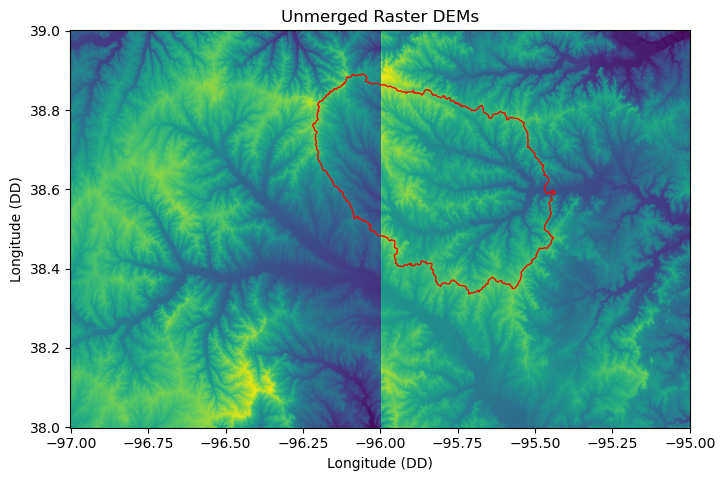

In [3]:
## Few variables from previous DEM Access Modules
site_id ='06913000' #two raster files to cover the entire watershed
#site_id='02013000' #only one raster file to cover the entire watershed #this used a check
resolution='1'
folder_input=f'./input_{site_id}'
#folder_input=f'C:/temp/JibinJoseph/GDAL_operations/inputa_{site_id}'
#folder_input_abs=f'/home/jovyan/hydroewd/inputa_{site_id}'
watershed = NLDI().get_basins(site_id)
extents_basin=watershed.total_bounds
extent_left=abs(math.floor(extents_basin[0]))
extent_right=abs(math.floor(extents_basin[2]))
extent_bottom=abs(math.ceil(extents_basin[1]))
extent_top=abs(math.ceil(extents_basin[3]))
num_tiles_download=(((extent_left+1)-extent_right)*((extent_top+1)-extent_bottom))

fig, ax = plt.subplots(figsize=(8, 8))

for lon in range(extent_right,extent_left+1,1):
    for lat in range(extent_bottom,extent_top+1,1):
        usgs_filename=f'n{lat:02d}w{lon:03d}'
        
        local_raster_filename=fr'{folder_input}/USGS_{resolution}_{usgs_filename}.tif'
        raster = rasterio.open(local_raster_filename)
        rasterio.plot.show(raster,
                           ax=ax,
                           cmap='viridis')
        #print(f'lat: {lat},lon: {lon},file:{local_fileloc_filename}')
del lat,lon
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
plt.title("Unmerged Raster DEMs")
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")

## Free up memory
del raster
del fig,ax

## <span style="color:green">Step 2: Merging the raster</span> 

<ul>
<li>Input: <span style="color:red">xxx</span></li>
<li>Output: <span style="color:red">xxxx</span></li>
<li>Output: <span style="color:red">xxxx</span></li>
    

## <span style="color:green">Step 2a: Create folder for saving the intermediate files</span>

<ul>
<li> Extents of the basin (watershed) is obtained using .total_bounds </li>
<li> Then we will find the bounding extents using math floor and ceil function </li>
    

In [4]:
def check_create_path_func(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"The new directory \033[1m'{path}'\033[0m is created!")
    else:
        print(f"The new directory \033[1m'{path}'\033[0m is not created as it already exists!")
        
## Create the a folder for intermediate raster files 
## WRITE CODE BELOW
folder_intermediate=f'./intermediate_{site_id}'
#folder_intermediate=f'C:/temp/JibinJoseph/GDAL_operations/intermediate_{site_id}'
check_create_path_func(folder_intermediate)

The new directory './intermediate_06913000' is not created as it already exists!


## <span style="color:green">Step 2b: Merging the rasters (if required)</span>

<ul>
<li> Define a function for merging the raster files </li>
<li> Create a filename for saving the merged raster files </li>
<li> Call the defined function merging the rasters</li>

In [5]:
def merge_dem_raster_func(input_foldername, output_filename):
    ## Get a list of all DEM files in the input folder
    dem_files = [f for f in os.listdir(input_foldername) if f.startswith(f"USGS_{resolution}_")]

    ## Create a list to store the raster datasets
    datasets = []

    ## Open each DEM file and append it to the datasets list
    for dem_file in dem_files:
        file_path = os.path.join(input_foldername, dem_file)
        src = rasterio.open(file_path)
        datasets.append(src)

    ## Merge the raster datasets into a single mosaic
    mosaic, out_trans = merge(datasets)

    ## Copy the metadata from one of the datasets (assuming they all have the same metadata)
    out_meta = datasets[0].meta.copy()
    out_meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': out_trans
    })

    # Write the mosaic to the output file
    with rasterio.open(output_filename, 'w', **out_meta) as dest:
        dest.write(mosaic)

    ## Close all the opened datasets
    for dataset in datasets:
        dataset.close()

    print(f"Merging completed for {num_tiles_download} DEM raster files")

## WRITE THE CODE BELOW 
if num_tiles_download==1:
    merged_raster_filename=f'{folder_input}/USGS_{resolution}_{usgs_filename}.tif'
    print("No need to merge as only one tiff file")
    title_4_plot="Original DEM Raster (Merging not required)"
else:
    merged_raster_filename=f'{folder_intermediate}/merged_{resolution}_{site_id}.tif'
    merge_dem_raster_func(folder_input, merged_raster_filename)
    title_4_plot="Merged DEM Raster"

Merging completed for 2 DEM raster files


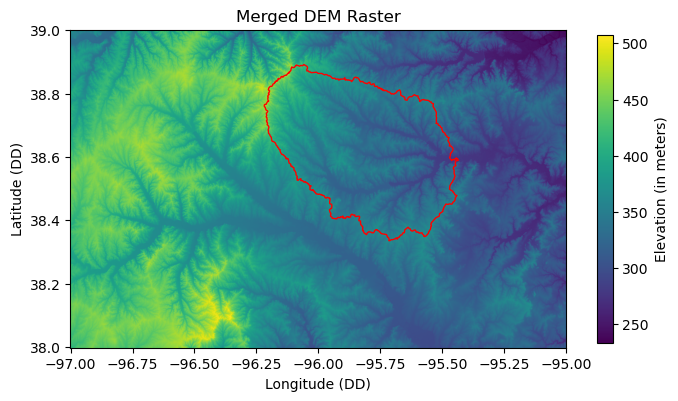

In [6]:
with rasterio.open(merged_raster_filename) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Longitude (DD)")
    ax.set_ylabel("Latitude (DD)")
    ax.set_title(title_4_plot)
    
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()

## <span style="color:green">Step 3: Reproject both shapefile and the raster to PCS from GCS</span>

<ul>
<li> Find the UTM Zone for Projected Coordinate System using the centroid point </li>
<li> Project the merged dem </li>

In [7]:
## Find if basin has a projection
print(watershed.crs)

EPSG:4326


In [8]:
## Find the approximate centroid
df=watershed
df['geometry'].centroid
## Find the center point
df['Center_point'] = df['geometry'].centroid
## Extract lat and lon from the centerpoint
df["lon"] = df.Center_point.map(lambda p: p.x)
df["lat"] = df.Center_point.map(lambda p: p.y)
df

/tmp/ipykernel_688/2437152260.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['geometry'].centroid
/tmp/ipykernel_688/2437152260.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid


,geometry,Center_point,lon,lat
identifier,,,,
USGS-06913000,"POLYGON ((-95.45447 38.56809, -95.45470 38.563...",POINT (-95.81635 38.62261),-95.816354,38.622613


## <span style="color:green">Step 3a: Finding the UTM Zone</span>

<ul>
<li> Find whether the centroid is in N or S </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>


In [9]:
## Calculate N or S
if 0 < df['lat'][0] < 84:
    lat_zone='N'
elif -84 < df['lat'][0] < 0:
    lat_zone='S'

## Calculate zone 
## Applicable for US only

if -138 < df['lon'][0] < -132:
    zone_value='08'
elif -132 < df['lon'][0] < -126:
    zone_value='09'
elif -126 < df['lon'][0] < -120:
    zone_value='10'
elif -120 < df['lon'][0] < -114:
    zone_value='11'
elif -114 < df['lon'][0] < -108:
    zone_value='12'
elif -108 < df['lon'][0] < -102:
    zone_value='13'
elif -102 < df['lon'][0] < -96:
    zone_value='14'
elif -96 < df['lon'][0] < -90:
    zone_value='15'
elif -90 < df['lon'][0] < -84:
    zone_value='16'
elif -84 < df['lon'][0] < -78:
    zone_value='17'
elif -78 < df['lon'][0] < -72:
    zone_value='18'
elif -72 and df['lon'][0] < -66:
    zone_value='19'
elif -66 < df['lon'][0] < -60:
    zone_value='20'    
elif -60 < df['lon'][0] < -54:
    zone_value='21'
elif -54 < df['lon'][0] < -48:
    zone_value='22'      
else:
    print("not in conterminous US")
    
crs_string=f'EPSG:326{zone_value}'
crs_string

'EPSG:32615'

In [10]:
## Alternative Method to estimate the CRS
crs_string2=watershed.estimate_utm_crs(datum_name='WGS 84')
crs_string2

<Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## <span style="color:green">Step 3b: Reprojecting watershed shapefile to UTM using calculated zone</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [11]:
folder_results=f'./results_{site_id}'
#folder_results=f'C:/temp/JibinJoseph/GDAL_operations/results_{site_id}'
check_create_path_func(folder_results)

shapefile_fileloc_filename=f'{folder_input}/shape_{site_id}.shp'
watershed_file=geopandas.read_file(shapefile_fileloc_filename)
watershed_proj=watershed_file.to_crs(crs_string)

The new directory './results_06913000' is created!


In [12]:
print(watershed_file.crs)
print(watershed_proj.crs)
print(type(watershed_file))
print(type(watershed_proj))

EPSG:4326
EPSG:32615
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
proj_shapefile_filename=f'{folder_results}/proj_shp_{site_id}.shp'
print(proj_shapefile_filename)
watershed_proj.to_file(proj_shapefile_filename, driver='ESRI Shapefile',mode='w')

./results_06913000/proj_shp_06913000.shp


## <span style="color:green">Step 3c: Reprojecting merged raster to UTM using calculated zone</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [14]:
def reproject_raster_func(input_raster, output_raster, target_crs):
    # Load the input DEM
    with rasterio.open(input_raster) as src:
        # Define the target CRS
        target_crs_proj = pyproj.CRS.from_string(target_crs)
        
        # Calculate the transformation and new dimensions
        transform, width, height = calculate_default_transform(src.crs, target_crs_proj, src.width, src.height, *src.bounds)

        # Update metadata for the new dataset
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs_proj,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the output dataset and perform the reprojection
        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs_proj,
                    resampling=Resampling.nearest
                )

    print("Reprojection complete.")

## WRITE CODE BELOW
reprojected_raster_filename=f'{folder_intermediate}/reprojected_{resolution}_{site_id}.tif'
reproject_raster_func(merged_raster_filename, reprojected_raster_filename, crs_string)

Reprojection complete.


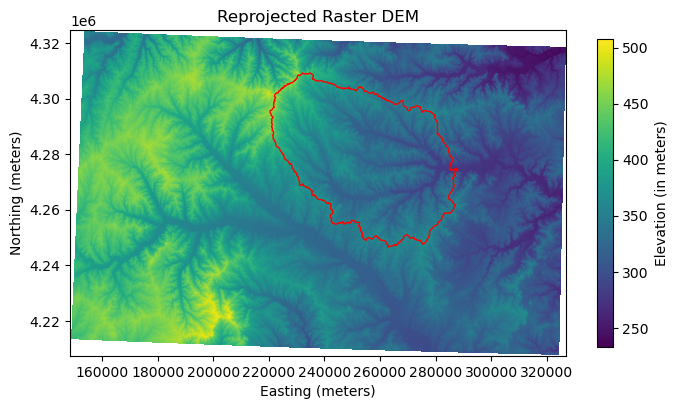

In [15]:
with rasterio.open(reprojected_raster_filename) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title("Reprojected Raster DEM")

## Uee the reprojected watershed shapefile
watershed_proj.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()

## <span style="color:green">Step 4: Clipping the reprojected raster file using watershed shapefile</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [16]:
def clip_raster_with_shapefile_func(input_raster, output_raster, shapefile):
    ## Open the shapefile using geopandas
    shapefile_gdf = geopandas.read_file(shapefile)
    
    ## Open the input raster
    with rasterio.open(input_raster) as src:
        ## Convert the shapefile geometry to the same CRS as the raster
        shapefile_gdf = shapefile_gdf.to_crs(src.crs)
        
        ## Convert the shapefile geometry to GeoJSON-like format
        geoms = [mapping(geom) for geom in shapefile_gdf.geometry]
        
        ## Clip the raster using the shapefile geometry
        clipped, out_transform = mask(src, geoms, crop=True)
        
        ## Update metadata for the new dataset
        out_meta = src.meta.copy()
        out_meta.update({
            'height': clipped.shape[1],
            'width': clipped.shape[2],
            'transform': out_transform
        })
        
        ## Write the clipped raster to the output file
        with rasterio.open(output_raster, 'w', **out_meta) as dst:
            dst.write(clipped)

    print("Raster clipping complete.")

## WRITE THE CODE BELOW    
clipped_raster_filename=f'{folder_results}/clipped_raster_{site_id}.tif'
clip_raster_with_shapefile_func(reprojected_raster_filename,clipped_raster_filename,proj_shapefile_filename)

Raster clipping complete.


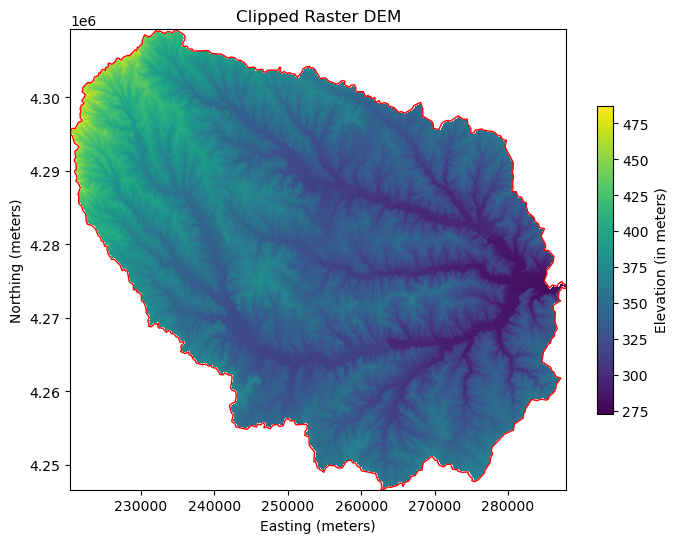

In [17]:
with rasterio.open(clipped_raster_filename) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title("Clipped Raster DEM")

## Uee the reprojected watershed shapefile
watershed_proj.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()